In [85]:
import numpy as np
from scipy import optimize as opt
from scipy.interpolate import UnivariateSpline as uni
import matplotlib.pyplot as plt


### Podatki DIN 8190 (8191)

In [86]:
# Oblika [ime, p, f, g1, g2, 2c, u, y]
podatki = [['06', 9.525, 3.76, 10.9, 6.7, 3, 9, 0.6],
           ['08', 12.7, 5.085, 14.45, 8.7, 4.2, 12.6, 0.6],
           ['12', 19.05, 7.44, 21, 10.7, 1.3, 15, 0.5],
           ['16', 25.4, 10.04, 27.7, 14, 1.8, 20, 0.5],
           ['24', 38.1, 14.95, 41, 21, 2.8, 30, 0.5],
           ['32', 50.8, 19.93, 55, 28, 3.6, 40, 0.5]]
omega = 200  # s^-1

### Člen

In [87]:
class Clen():
    
    def __init__(self, podatki_i):
        ime, self.p, self.f, g1, g2, c, u, y = podatki_i

        # Podatki
        self.alpha_k = 30
        self.alpha_r = np.deg2rad(self.alpha_k)
        self.a = 0.8567 * self.p
        self.f = 0.6128 * self.a  # ali upoštevam f iz standarda ali računskega
        self.L = 1.86 * self.p
        self.h1 = 0.33 * self.p
        self.h2 = 0.7 * self.p
        self.h3 = 1.115 * self.p

        # Po izbiri
        self.r0 = 28
        self.r1 = 2.6
        self.r2 = 5.5
        self.r3 = 1.2
        self.r4 = 14.3
        self.r5 = 1.8
    
        # Resevanje
        zac_priblizki = np.ones(28)
        resitev = list(opt.fsolve(self.enacbe, zac_priblizki))

        # +- 2 * pi, da dobmo prave dele kroga
        for i, element in enumerate(resitev):
            if i < 14 and (i != 7 or i != 8):
                if element > 2 * np.pi:
                    resitev[i] = element - 2 * int(element / (2 * np.pi)) * np.pi
                elif - element > 2 * np.pi:
                    resitev[i] = element + 2 * int(-element / (2 * np.pi)) * np.pi
                if i % 2 == 1 and i < 12:
                    if resitev[i] < resitev[i - 1]:
                        resitev[i] += 2 * np.pi
        if resitev[13] > 2 * np.pi:
            resitev[13] -= 2 * np.pi
        if resitev[13] > resitev[12]:
            resitev[12] += 2 * np.pi

        t1A, t1B, t2B, t2C, t3C, t3D, t4D, t4E, t5E, t5F, t6F, t6G, t7G, t7H, x01, y01, x02, y02, \
        x03, y03, x04, y04, x05, y05, x06, y06, x07, y07 = resitev

        # Zbiranje rezultatov

        st_t_c = 300  # Število_točk_člen -> število točk, ki jih uporabim na posamezni krivulji  500
        self.x0 = []
        self.y0 = []
        funkcije = [self.x1, self.y1, self.x2, self.y2, self.x3, self.y3, self.x4, self.y4, self.x5, self.y5,
                    self.x6, self.y6, self.x7, self.y7]
        konst = [x01, y01, x02, y02, x03, y03, x04, y04, x05, y05, x06, y06, x07, y07]
        for i in range(0, 14, 2):
            zac, kon = resitev[i], resitev[i+1]
            t = np.linspace(zac, kon, st_t_c)
            self.x0.append(funkcije[i](t, konst[i])-self.a / 2)  # Doda posamezen odsek x na skupni seznam tocke_clen_x
            self.y0.append(funkcije[i+1](t, konst[i+1]))  # Doda posamezen odsek y na skupni seznam tocke_clen_y
        
        self.x = self.x0[::]
        self.y = self.y0[::]
        for i in range(len(self.x)):
            self.x.append(-self.x0[-(i+1)][::-1])
            self.y.append(np.array(self.y0[-(i+1)][::-1]))
        self.x = np.array(self.x)
        self.y = np.array(self.y)
    
    # Enacbe
    # AB
    def x1(self, t1, x01):
        return x01 + self.r0 * np.cos(t1)
    def y1(self, t1, y01):
        return y01 + self.r0 * np.sin(t1)
    # BC
    def x2(self, t2, x02):
        return x02 + self.r1 * np.cos(t2)
    def y2(self, t2, y02):
        return y02 + self.r1 * np.sin(t2)
    # CD
    def x3(self, t3, x03):
        return x03 + self.r2 * np.cos(t3)
    def y3(self, t3, y03):
        return y03 + self.r2 * np.sin(t3)
    # DE
    def x4(self, t4, x04):
        return x04 + t4 * np.sin(self.alpha_r)
    def y4(self, t4, y04):
        return y04 - t4 * np.cos(self.alpha_r)
    # EF
    def x5(self, t5, x05):
        return x05 + self.r3 * np.cos(t5)
    def y5(self, t5, y05):
        return y05 + self.r3 * np.sin(t5)
    # FG
    def x6(self, t6, x06):
        return x06 + self.r4 * np.cos(t6)
    def y6(self, t6, y06):
        return y06 + self.r4 * np.sin(t6)
    # GH
    def x7(self, t7, x07):
        return x07 + self.r5 * np.cos(t7)
    def y7(self, t7, y07):
        return y07 + self.r5 * np.sin(t7)
    
    # Sistem enacb
    def enacbe(self, priblizki):
        '''Potrebujem pri določanju geometrije zobnika'''
        t1A, t1B, t2B, t2C, t3C, t3D, t4D, t4E, t5E, t5F, t6F, t6G, t7G, t7H, \
        x01, y01, x02, y02, x03, y03, x04, y04, x05, y05, x06, y06, x07, y07 = priblizki
        # Zveznost x: 6
        e1 = self.x2(t2B, x02) - self.x1(t1B, x01)
        e2 = self.x3(t3C, x03) - self.x2(t2C, x02)
        e3 = self.x4(t4D, x04) - self.x3(t3D, x03)
        e4 = self.x5(t5E, x05) - self.x4(t4E, x04)
        e5 = self.x6(t6F, x06) - self.x5(t5F, x05)
        e6 = self.x7(t7G, x07) - self.x6(t6G, x06)
        # Zveznost y: 6
        e7 = self.y2(t2B, y02) - self.y1(t1B, y01)
        e8 = self.y3(t3C, y03) - self.y2(t2C, y02)
        e9 = self.y4(t4D, y04) - self.y3(t3D, y03)
        e10 = self.y5(t5E, y05) - self.y4(t4E, y04)
        e11 = self.y6(t6F, y06) - self.y5(t5F, y05)
        e12 = self.y7(t7G, y07) - self.y6(t6G, y06)
        # Odvodi: 8
        e13 = np.pi / 2 - t1A
        e14 = t2B - t1B
        e15 = t3C - t2C
        e16 = np.pi + self.alpha_r - t3D
        e17 = t3D - t5E
        e18 = t6F - t5F
        e19 = t7G - np.pi - t6G
        e20 = np.pi / 2 - t7H
        # Ostalo: 8
        e21 = 0.5 * self.a - self.x1(t1A, x01)
        e22 = self.h1 - self.y1(t1A, y01)
        e23 = 0.5 * self.a - 0.5 * self.L - self.x3(t3C, x03)
        e24 = - self.f * np.cos(self.alpha_r) - self.x4(t4D, x04)
        e25 = - self.f * np.sin(self.alpha_r) - self.y4(t4D, x04)
        e26 = self.h1 - self.h3 - self.y5(t5F, y05)
        e27 = self.h1 - self.h2 - y07
        e28 = 0.5 * self.a - self.x7(t7H, x07)
        return (e1, e2, e3, e4, e5, e6, e7, e8, e9, e10, e11, e12, e13, e14, e15, e16, e17, e18, e19, e20,
                e21, e22, e23, e24, e25, e26, e27, e28)
    
    def izris(self):
        "Izriše clen."
        plt.plot(self.x.flatten(), self.y.flatten(), 'b')
        plt.axis('equal')
        plt.grid()
        
    def rotacija(self, kot):  # kot v rad
        '''Naceloma je za clen ne potrebujem.'''
        for i, odsek_x, odsek_y in zip(range(len(self.x)), self.x, self.y):
            for j, x_z, y_z in zip(range(len(odsek_x)), odsek_x, odsek_y):
                x_n = x_z * np.cos(kot) - y_z * np.sin(kot)  # novi x
                y_n = x_z * np.sin(kot) + y_z * np.cos(kot)  # novi y
                self.x[i][j] = x_n
                self.y[i][j] = y_n
                
    def translacija_x(self, pomik):
        '''Za pomik premakne clen po x osi.'''
        self.x += pomik
        
    def translacija_y(self, pomik):
        '''Za pomik premakne clen po y osi.'''
        self.y += pomik


### Verižnik

In [88]:
class Veriznik():
    
    def __init__(self, podatki_i, z):

        self.ime, p, f, g1, g2, c, u, y = podatki_i
        z = z
        
        alpha_k = 30
        alpha_r = np.deg2rad(alpha_k)
        razdelni_premer = (z * p) / np.pi
        osnovni_premer = razdelni_premer * np.cos(alpha_r)
        addendum = 1 * p / np.pi
        dedendum = 1.25 * p / np.pi
        self.zunanji_premer = razdelni_premer + 2 * addendum
        krozni_korak = p / (razdelni_premer / 2)
        zracnost = 0.05  # zračnost - luknja in zob na razdelnem krogu nista točno 1/2, ampak je zob malo ožji
        krozna_debelina_zoba = p / (2 + zracnost)
        krozni_kot_zoba = krozna_debelina_zoba / (razdelni_premer / 2)

        u = 0
        r_trenutni = 0
        x_evo0 = [self.f_x_evolventa(osnovni_premer / 2, u)]
        y_evo0 = [self.f_y_evolventa(osnovni_premer / 2, u)]
        while r_trenutni < self.zunanji_premer / 2:
            napaka = 0.00001  # korak po katerem se pomika cez točke  0.000002
            u += napaka
            x_trenutni = self.f_x_evolventa(osnovni_premer / 2, u)
            y_trenutni = self.f_y_evolventa(osnovni_premer / 2, u)
            x_evo0.append(x_trenutni)
            y_evo0.append(y_trenutni)
            r_trenutni = np.sqrt(x_trenutni ** 2 + y_trenutni ** 2)
            if abs(r_trenutni - razdelni_premer / 2) <= ((razdelni_premer - osnovni_premer) / 2) / len(x_evo0):
                xy_razdelni = (x_trenutni, y_trenutni)

        zeljeno_stevilo_tock = 300  # število točk, ki jih uporabim na posameznem odseku. Če to želim zvečati,
                                    # moram zmanjšati korak! Drugače analiza: "Error: array without sequence."  500
        korak_po_tockah = int(len(x_evo0) / zeljeno_stevilo_tock) + 1
        x_evo1 = x_evo0[::korak_po_tockah]
        y_evo1 = y_evo0[::korak_po_tockah]

        phi = np.arctan(xy_razdelni[1] / xy_razdelni[0])    
        x_evo1a, y_evo1a = self.obrni(x_evo1, y_evo1, -phi)

        y_evo1_z = -y_evo1a  # zrcalno
        x_evo2, y_evo2 = self.obrni(x_evo1a, y_evo1a, - krozni_kot_zoba / 2)
        x_evo2_z, y_evo2_z = self.obrni(x_evo1a, y_evo1_z, krozni_kot_zoba / 2)
        x_evo2_v = np.zeros(zeljeno_stevilo_tock) + x_evo2[-1]  # vmes
        y_evo2_v = np.linspace(y_evo2_z[-1], y_evo2[-1], zeljeno_stevilo_tock)

        xz0, yz0 = self.obrni(x_evo2_z, y_evo2_z, np.pi / 2 + krozni_korak)
        xz1, yz1 = self.obrni(x_evo2_v, y_evo2_v, np.pi / 2 + krozni_korak)
        xz2, yz2 = self.obrni(x_evo2[::-1], y_evo2[::-1], np.pi / 2 + krozni_korak)

        xz3, yz3 = self.obrni(x_evo2_z, y_evo2_z, np.pi / 2)
        xz4, yz4 = self.obrni(x_evo2_v, y_evo2_v, np.pi / 2)
        xz5, yz5 = self.obrni(x_evo2[::-1], y_evo2[::-1], np.pi / 2)

        xz6, yz6 = self.obrni(x_evo2_z, y_evo2_z, np.pi / 2 - krozni_korak)
        xz7, yz7 = self.obrni(x_evo2_v, y_evo2_v, np.pi / 2 - krozni_korak)
        xz8, yz8 = self.obrni(x_evo2[::-1], y_evo2[::-1], np.pi / 2 - krozni_korak)

        self.x = np.array([xz0, xz1, xz2, xz3, xz4, xz5, xz6, xz7, xz8])
        self.y = np.array([yz0, yz1, yz2, yz3, yz4, yz5, yz6, yz7, yz8])
    
    def obrni(self, seznam_x, seznam_y, kot):  # kot v rad
        '''Ta funkcija nam služi le pri obračanju delov, ko sestavljamo zobnik. V nadaljevanju za vrtenje zobnika
        uporabljamo metodo rotacija.'''
        nov_seznam_x = []
        nov_seznam_y = []
        for x_z, y_z in zip(seznam_x, seznam_y):  # x_zacetni, y_zacetni
            x_n = x_z * np.cos(kot) - y_z * np.sin(kot)  # novi x
            y_n = x_z * np.sin(kot) + y_z * np.cos(kot)  # novi y
            nov_seznam_x.append(x_n)
            nov_seznam_y.append(y_n)
        return (np.array(nov_seznam_x), np.array(nov_seznam_y))

    def f_x_evolventa(self, a, u):
        return a * (np.cos(u) + u * np.sin(u))

    def f_y_evolventa(self, a, u):
        return a * (np.sin(u) - u * np.cos(u))
    
    def rotacija(self, kot):  # kot v rad
        '''Zavrti zobnik za kot "kot".'''
        for i, odsek_x, odsek_y in zip(range(len(self.x)), self.x, self.y):
            for j, x_z, y_z in zip(range(len(odsek_x)), odsek_x, odsek_y):
                x_n = x_z * np.cos(kot) - y_z * np.sin(kot)  # novi x
                y_n = x_z * np.sin(kot) + y_z * np.cos(kot)  # novi y
                self.x[i][j] = x_n
                self.y[i][j] = y_n
    
    def izris(self):
        "Izriše veriznik."
        plt.plot(self.x.flatten(), self.y.flatten(), 'r')
        plt.axis('equal')
        plt.grid()


### Preizkusa razredov

In [89]:
'''
# Preizkus razreda clen:
c = clen(podatki[0])
c.rotacija(np.pi / 6)
c.translacija_x(5)
c.izris()
''';


In [90]:
'''
# Preizkus razreda verižnik:
v = Veriznik(podatki[0], 35)
v.rotacija(-np.pi/10)
v.izris()
''';


### Analiza

In [91]:
def premicno_povprecje(array, st_tock):
    na = []
    st_pred = int((st_tock-1)/2)  # število točk pred in za sredinsko
    na.append(array[0])
    for i in range(1, st_pred):
        na.append(np.average(array[0:i]))
    for i in range(st_pred, int(len(array)-st_pred)):
        na.append(np.average(array[i-int((st_tock-1)/2):i+st_pred]))
    for i in range(1, st_pred + 1)[::-1]:
        na.append(array[-i])
    return na


In [109]:
class Analiza():
    
    '''Vzame podatke za clen in veriznik (podatki_i in z) in ju pribliza s funkcijo priblizaj.
    Nato ju zavrti in vrne tocke kontakta.'''
    
    def __init__(self, podatki_i, z, kot_analize):
        self.c = Clen(podatki_i)
        self.v = Veriznik(podatki_i, z)
        self.kot_analize = kot_analize
        
        # Skupni seznami
        self.x_c = []
        self.y_c = []
        self.x_v = []
        self.y_v = []
        
        self.priblizaj()
        self.izris()
        self.analiza = True
        while self.analiza == True:
            #self.izris()
            self.nov_korak_obravnave()
            
        # Ogled in prilagajanje rezultatov
        self.izris_ubirnice()
        self.glajenje_ubirnice()
        self.izris_ubirnice()
        self.relativne_hitrosti()
            
    def priblizaj(self):
        
        '''Pribliza clen in verižnik v prvo situacijo za analizo'''
        # Premik člena
        self.c.translacija_y(self.v.zunanji_premer)

        # Iskanje začetne zračnosti - gledam le na spoj med levim delom člena in levim zobom
        min_razdalja = None
        for i, (x_c, y_c) in enumerate(zip(self.c.x[3], self.c.y[3])):
            for j, (x_v, y_v) in enumerate(zip(self.v.x[2], self.v.y[2])):
                try:  # Zadnjega clena ne more, ker je index out of range [i+1]
                    if abs(x_v - x_c) < abs(x_c - self.c.x[3][i+1])/2:  # and abs(x_v - x_c) < abs(x_v - self.v.x[[2],[j+1]])/2:
                        razdalja = y_c - y_v
                        if razdalja < 0:
                            raise Exception("Se že sekata!")
                        elif min_razdalja == None or razdalja < min_razdalja[-1]:
                            min_razdalja = [i, j, x_c, y_c, x_v, y_v, razdalja]
                except:  # Za try mora vedno pridet še except.
                    break
        self.c.translacija_y(-min_razdalja[-1])
        
        # Pripenjanje v sezname
        self.x_c.append(min_razdalja[2])
        self.y_c.append(min_razdalja[5] - min_razdalja[-1])
        self.x_v.append(min_razdalja[4])
        self.y_v.append(min_razdalja[5])
        
    def nov_korak_obravnave(self):
        '''Obrne zobnik, približa člen in vpiše točke kontakta'''
        self.v.rotacija(-self.kot_analize)
        
        min_razdalja = None
        for i, (x_c, y_c) in enumerate(zip(self.c.x[3], self.c.y[3])):
            for j, (x_v, y_v) in enumerate(zip(self.v.x[2], self.v.y[2])):
                try:  # Zadnjega clena ne more, ker je index out of range [i+1]
                    if abs(y_v - y_c) < abs(y_c - self.c.y[3][i+1])/2 and abs(y_v - y_c) < abs(y_v - self.v.y[[2],[j+1]])/2:
                        razdalja = x_v - x_c
                        if razdalja < 0:
                            raise Exception("Se ne sekata!")
                        elif min_razdalja == None or razdalja > min_razdalja[-1]:
                            min_razdalja = [i, j, x_c, y_c, x_v, y_v, razdalja]
                except:  # Za try mora vedno pridet še except.
                    break

        if min_razdalja:
            self.c.translacija_x(min_razdalja[-1])

            # Pripenjanje v sezname
            self.x_c.append(min_razdalja[2])
            self.y_c.append(min_razdalja[3] - min_razdalja[-1])
            self.x_v.append(min_razdalja[4])
            self.y_v.append(min_razdalja[5])
            
        else:
            self.analiza = False  # Izklopi while zanko
                      
    def izris(self):
        '''Izriše člen in verižnik.'''
        self.c.izris()
        self.v.izris()
        plt.show()
    
    def izris_ubirnice(self):
        # Predpostavka kontaktne točke verižnika in člena so enake - zanemarimo napako numerične metode.
        plt.plot(self.x_v, self.y_v, 'g.')
        plt.title("Ubirnica")
        plt.xlabel("mm")
        plt.ylabel("mm")
        plt.show()
        
    def glajenje_ubirnice(self):
        print("Glajenje ubirnice...")
        self.x_g = premicno_povprecje(self.x_v, 7)
        self.y_g = premicno_povprecje(self.y_v, 7)
        self.x_v = self.x_g
        self.y_v = self.y_g
    
    def relativne_hitrosti(self):
        self.rel_hitrosti = []
        self.koti_kontakta = []
        self.koti_veriznika = []
        kot_veriznika = np.pi / 2
        for x, y in zip(self.x_v, self.y_v):
            r = np.sqrt(x ** 2 + y ** 2)
            v_obodna = omega * r
            alpha = np.arctan(y / x)
            if alpha < 0:
                alpha += np.pi
            phi = alpha - self.c.alpha_r
            v_rel = v_obodna * np.cos(phi)
            self.rel_hitrosti.append(v_rel)
            self.koti_kontakta.append(np.rad2deg(alpha))
            self.koti_veriznika.append(np.rad2deg(kot_veriznika))
            kot_veriznika -= self.kot_analize
            
        # Izris
        plt.plot(self.koti_kontakta, self.rel_hitrosti, '.')
        plt.title('Relativne hitrosti v odvisnosti od kota kontakta')
        plt.xlabel('°')
        plt.ylabel("$\\frac{m}{s}$")
        plt.show()
        
        plt.plot(self.koti_veriznika, self.rel_hitrosti, '.')
        plt.title('Relativne hitrosti v odvisnosti od kota veriznika')
        plt.xlabel('°')
        plt.ylabel("$\\frac{m}{s}$")
        plt.show()


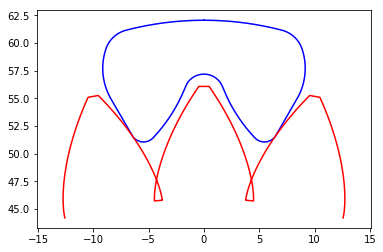

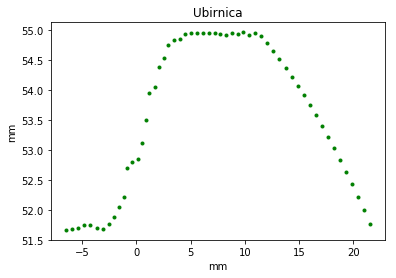

Glajenje ubirnice...


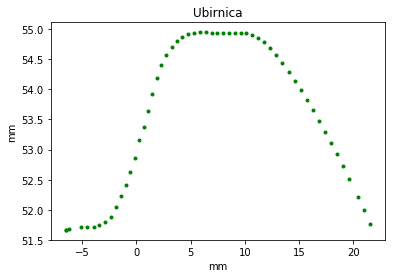

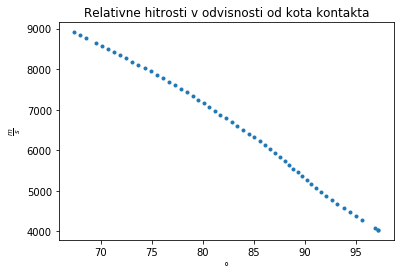

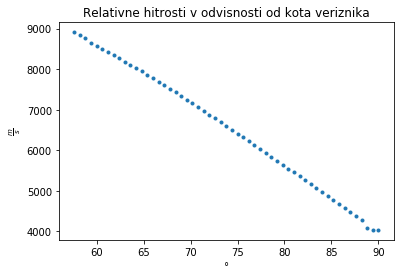

In [110]:
a = Analiza(podatki[0], 35, np.pi/300)  # Dobro: st tock obeh 500, pi/500, korak = 0.000002
# Če želim pohitrit, spremeni št točk verižnika in
# predvsem korak zanko prej -> "napaka".
